
### stacked map of galaxy pairs from pair catalog


Stacking pairs: 100%|██████████| 72540/72540 [00:38<00:00, 1863.78it/s]


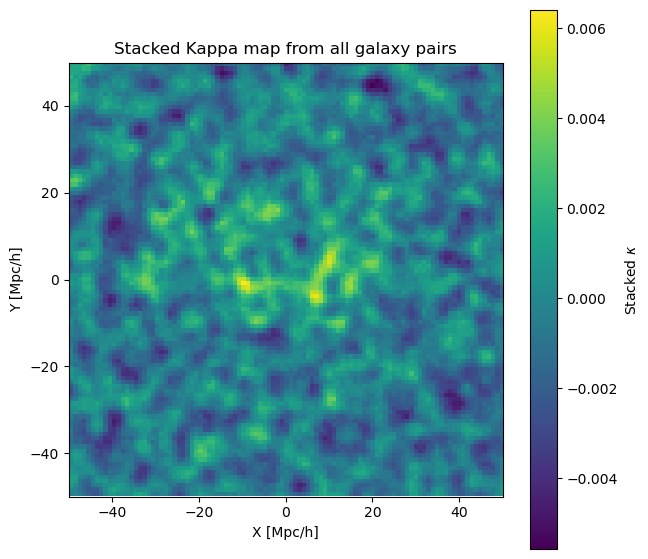

In [11]:
import numpy as np
import healpy as hp
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # progress bar

# --- Load catalog and map as before ---
pairs = pd.read_csv('data/galaxy_pairs_catalog_20hmpc.csv')
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"
nside = 2048

alm_data = hp.read_alm(alm_file)
lmax = hp.Alm.getlmax(len(alm_data))
kmap = hp.alm2map(hp.smoothalm(alm_data, fwhm=np.radians(8/60)), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Grid parameters ---
grid_size = 100.0 # Mpc/h box size
grid_res = 101
half_size = grid_size / 2
X_vals = np.linspace(-half_size, half_size, grid_res)
Y_vals = np.linspace(-half_size, half_size, grid_res)
X_grid, Y_grid = np.meshgrid(X_vals, Y_vals)

# Initialize stack accumulators
kappa_stack_sum = np.zeros((grid_res, grid_res))
weight_stack_sum = np.zeros((grid_res, grid_res))

# Loop over all pairs
for idx, pair in tqdm(pairs.iterrows(), total=len(pairs), desc="Stacking pairs"):
    # Extract pair data (convert to radians)
    l1, b1, z1 = np.deg2rad(pair['l1']), np.deg2rad(pair['b1']), pair['z1']
    l2, b2, z2 = np.deg2rad(pair['l2']), np.deg2rad(pair['b2']), pair['z2']

    # --- Enforce consistent ordering of longitudes ---
    # Compute raw difference, wrapped into [-π, π]
    dl_raw = (l2 - l1 + np.pi) % (2*np.pi) - np.pi

    # If "l2 is to the left of l1", swap them
    if dl_raw < 0:
        l1, l2 = l2, l1
        b1, b2 = b2, b1
        z1, z2 = z2, z1
        dl_raw = -dl_raw   # now positive

    # --- Midpoint (wrap-safe) ---
    lc = l1 + 0.5 * dl_raw
    bc = 0.5 * (b1 + b2)
    zbar = 0.5 * (z1 + z2)
    Dc = cosmo.comoving_distance(zbar).value * cosmo.h  # Mpc/h

    # --- Rotation angle θ ---
    dl = dl_raw * np.cos(bc)
    db = (b2 - b1)
    norm = np.hypot(dl, db)
    cos_theta, sin_theta = dl / norm, db / norm

    # Inverse transform (X,Y) -> (l,b)
    dl_cosbc = (cos_theta * (X_grid / Dc)) - (sin_theta * (Y_grid / Dc))
    db_grid = (sin_theta * (X_grid / Dc)) + (cos_theta * (Y_grid / Dc))
    l_grid = lc + dl_cosbc / np.cos(bc)
    b_grid = bc + db_grid

    # Convert to degrees
    l_grid_deg = np.rad2deg(l_grid)
    b_grid_deg = np.rad2deg(b_grid)

    # Convert to Healpix pixels
    l_grid_deg_wrapped = np.mod(l_grid_deg, 360)
    theta = np.radians(90 - b_grid_deg)
    phi = np.radians(l_grid_deg_wrapped)
    pix = hp.ang2pix(nside, theta.ravel(), phi.ravel())

    # Sample kappa and mask
    kappa_vals = kmap[pix].reshape(grid_res, grid_res)
    mask_vals = mask[pix].reshape(grid_res, grid_res)

    # Mask out invalid pixels
    valid_mask = (mask_vals != 0) & np.isfinite(kappa_vals)
    kappa_vals[~valid_mask] = 0.0

    # Weights: if you have pair weights, use them here
    weight = 1.0  # equal weighting for now

    # Accumulate weighted sum and weights
    kappa_stack_sum += weight * kappa_vals
    weight_stack_sum += weight * valid_mask.astype(float)

# Avoid division by zero
nonzero = weight_stack_sum > 0
kappa_stack_mean = np.zeros_like(kappa_stack_sum)
kappa_stack_mean[nonzero] = kappa_stack_sum[nonzero] / weight_stack_sum[nonzero]

# Plot stacked map
plt.figure(figsize=(7,7))
extent = [-half_size, half_size, -half_size, half_size]
im = plt.imshow(kappa_stack_mean, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(im, label=r'Stacked $\kappa$')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.title('Stacked Kappa map from all galaxy pairs')
plt.show()

In [12]:
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from helper import symmetrize_map
from helper import radial_profile

# kappa_smooth = gaussian_filter(kappa_stack_mean, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_stack_mean)

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:99: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


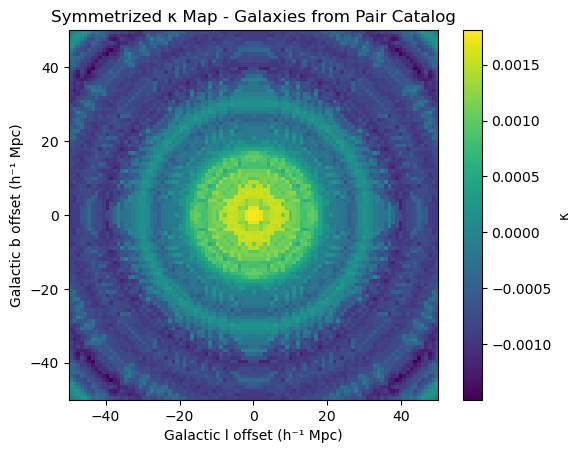

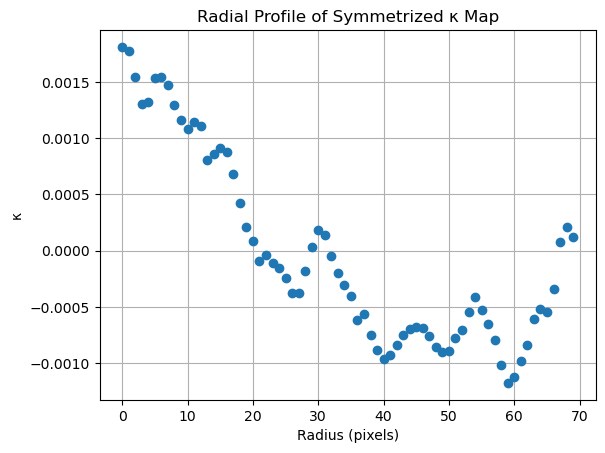

(array([ 1.81020132e-03,  1.77366701e-03,  1.54658382e-03,  1.30097724e-03,
         1.32068916e-03,  1.53027697e-03,  1.54399762e-03,  1.47279404e-03,
         1.29419169e-03,  1.16249483e-03,  1.08343711e-03,  1.14569389e-03,
         1.10764432e-03,  8.09032709e-04,  8.60446123e-04,  9.10751812e-04,
         8.81085809e-04,  6.81125390e-04,  4.25946408e-04,  2.12353595e-04,
         9.10826646e-05, -8.76129230e-05, -3.92077205e-05, -1.10322550e-04,
        -1.52361642e-04, -2.37354167e-04, -3.77216009e-04, -3.72470557e-04,
        -1.80994251e-04,  3.30642658e-05,  1.82205117e-04,  1.36310690e-04,
        -4.45224654e-05, -1.96048471e-04, -3.03873010e-04, -4.05499968e-04,
        -6.12462097e-04, -5.59486327e-04, -7.51815575e-04, -8.81214309e-04,
        -9.60359181e-04, -9.28059805e-04, -8.36131360e-04, -7.49569642e-04,
        -6.95656479e-04, -6.75504079e-04, -6.86925048e-04, -7.56712496e-04,
        -8.58806550e-04, -8.99776599e-04, -8.86244682e-04, -7.79010581e-04,
        -6.9

In [13]:
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title="Radial Profile of Symmetrized κ Map", zoom=70)

In [14]:
# The next section explores reflection symmetry enforcement
# The next graph is the one that I attached to the google doc

In [15]:
def reflect_symmetrize_map(kappa_map):
    """
    Apply reflection symmetry: for every (x,y), average values at
    (+/-x, +/-y) and assign the average to all four.
    Assumes kappa_map is square with odd dimensions (so center is defined).
    """
    sym_map = np.copy(kappa_map)
    n = kappa_map.shape[0]
    center = n // 2  # integer index of the center pixel

    for i in range(center + 1):       # only need to loop half
        for j in range(center + 1):
            # Offsets from the center
            di, dj = i - center, j - center

            # Four symmetric positions
            coords = [
                (center + di, center + dj),
                (center - di, center + dj),
                (center + di, center - dj),
                (center - di, center - dj),
            ]

            # Extract values
            vals = [kappa_map[x, y] for x, y in coords]

            # Compute mean
            avg_val = np.mean(vals)

            # Assign average back
            for x, y in coords:
                sym_map[x, y] = avg_val

    return sym_map

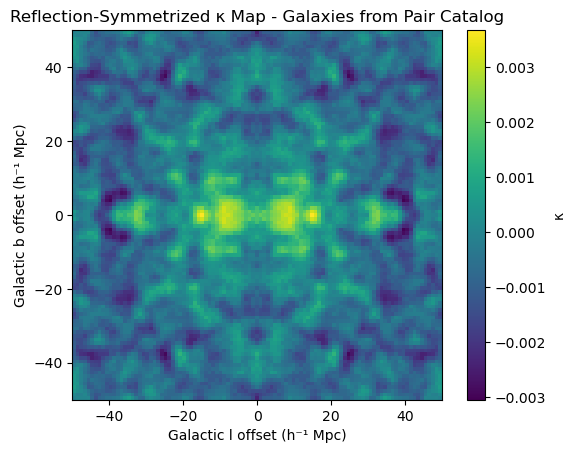

In [16]:
# --- Plot symmetrized map (reflection symmetry) ---
kappa_sym = reflect_symmetrize_map(kappa_stack_mean)
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Reflection-Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

In [17]:
def reflect_x_symmetrize_map(kappa_map):
    """
    Enforce reflection symmetry only across the Y axis:
    average (+x,y) and (-x,y).
    """
    sym_map = np.copy(kappa_map)
    n = kappa_map.shape[0]
    center = n // 2

    for i in range(center + 1):
        for j in range(n):
            di = i - center
            coords = [
                (center + di, j),
                (center - di, j),
            ]
            vals = [kappa_map[x, y] for x, y in coords]
            avg_val = np.mean(vals)
            for x, y in coords:
                sym_map[x, y] = avg_val
    return sym_map

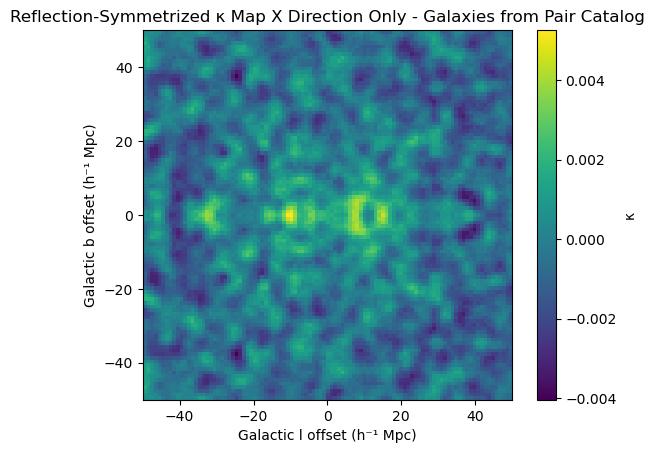

In [18]:
kappa_sym = reflect_x_symmetrize_map(kappa_stack_mean)
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Reflection-Symmetrized κ Map X Direction Only - Galaxies from Pair Catalog")
plt.show()

In [19]:
def reflect_x_symmetrize_map(kappa):
    """
    Enforce reflection symmetry across the Y axis (left/right):
    average (+x, y) with (-x, y). Works for odd-sized square maps.
    """
    h, w = kappa.shape
    assert h == w and (w % 2 == 1), "Map must be square with odd dim."
    c = w // 2  # center column

    sym = kappa.copy()

    # Left half incl. center vs right half reversed (for column mirror)
    left  = kappa[:, :c+1]           # columns [0..c]
    right = np.fliplr(kappa)[:, :c+1]  # mirror of columns [c..end]

    avg = 0.5 * (left + right)

    # Put averaged half back, then mirror it to the other side
    sym[:, :c+1] = avg
    sym[:, c:]   = np.fliplr(avg)
    return sym

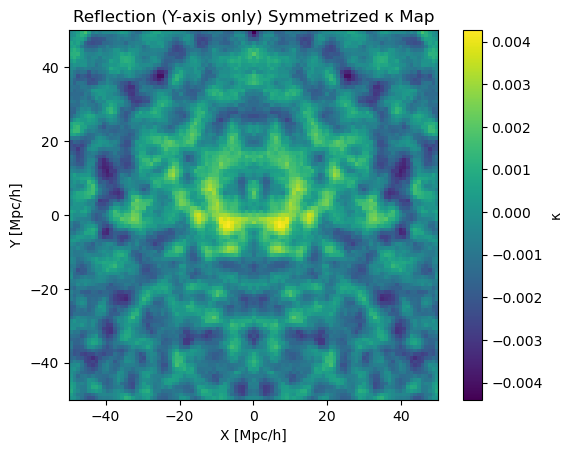

In [20]:
# kappa_smooth = gaussian_filter(kappa_stack_mean, sigma=2)
kappa_sym = reflect_x_symmetrize_map(kappa_stack_mean)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("X [Mpc/h]"); plt.ylabel("Y [Mpc/h]")
plt.title("Reflection (Y-axis only) Symmetrized κ Map")
plt.show()